In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk
import re
import keras
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint
#from tensorflow.keras.models import Sequential
from keras.layers.embeddings import Embedding
#from tensorflow.keras import backend
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.callbacks import TensorBoard
#import tensorflow
from warnings import filterwarnings
filterwarnings('ignore')

Using TensorFlow backend.


In [113]:
def load_dataset(filename):
  df = pd.read_csv(filename, encoding = "latin1", names = ["Sentence", "Intent"])
  print(df.head())
  intent = df["Intent"]
  Intents = list(set(intent))
  sentences = list(df["Sentence"])
  
  return (intent, unique_intent, sentences)

In [114]:
intent, unique_intent, sentences = load_dataset("Dataset.csv")

                Sentence          Intent
0       Need help pleese  commonQ.assist
1              Need help  commonQ.assist
2       I need some info  commonQ.assist
3      Will you help me?  commonQ.assist
4  What else can you do?  commonQ.assist


In [115]:
stemmer = LancasterStemmer()

In [116]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\venkey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\venkey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [117]:
def cleaning(sentences):
  words = []
  for s in sentences:
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
    w = word_tokenize(clean)
    #stemming
    words.append([i.lower() for i in w])
    
  return words

In [118]:
cleaned_words = cleaning(sentences)
#print(cleaned_words)
len(cleaned_words)

1113

In [119]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
  token = Tokenizer(filters = filters)
  token.fit_on_texts(words)
  return token

In [120]:
def max_length(words):
  return(len(max(words, key = len)))

In [121]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 492 and Maximum length = 28


In [122]:
def encoding_doc(token, words):
  return(token.texts_to_sequences(words))

In [123]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

In [124]:
def padding_doc(encoded_doc, max_length):
  return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [125]:
padded_doc = padding_doc(encoded_doc, max_length)

In [126]:
padded_doc[:5]

array([[ 25,  77, 332,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [ 25,  77,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  1,  25, 198, 181,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [ 51,  10,  77,  16,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  8, 268,   4,  10,  30,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])

In [127]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (1113, 28)


In [128]:
output_tokenizer = create_tokenizer(unique_intent, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')

In [129]:
output_tokenizer.word_index

{'faq.application_process': 1,
 'commonq.not_giving': 2,
 'commonq.query': 3,
 'faq.address_proof': 4,
 'commonq.name': 5,
 'contact.contact': 6,
 'faq.aadhaar_missing': 7,
 'faq.bad_service': 8,
 'faq.borrow_limit': 9,
 'commonq.assist': 10,
 'faq.biz_category_missing': 11,
 'faq.approval_time': 12,
 'commonq.how': 13,
 'faq.biz_simpler': 14,
 'commonq.bot': 15,
 'commonq.wait': 16,
 'faq.apply_register': 17,
 'commonq.just_details': 18,
 'faq.biz_new': 19,
 'faq.banking_option_missing': 20,
 'faq.borrow_use': 21}

In [130]:
encoded_output = encoding_doc(output_tokenizer, intent)

In [131]:
import numpy as np
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [132]:
encoded_output.shape

(1113, 1)

In [133]:
def one_hot(encode):
  o = OneHotEncoder(sparse = False)
  return(o.fit_transform(encode))

In [134]:
output_one_hot = one_hot(encoded_output)

In [135]:
output_one_hot.shape

(1113, 21)

In [136]:
from sklearn.model_selection import train_test_split

In [137]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.1)

In [138]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (1001, 28) and train_Y = (1001, 21)
Shape of val_X = (112, 28) and val_Y = (112, 21)


In [139]:
def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
  model.add(Bidirectional(LSTM(128)))
  model.add(Dense(50,activation='tanh'))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.25))
  model.add(Dense(21, activation = "softmax"))
  
  return model

In [140]:
model = create_model(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 28, 128)           62976     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_13 (Dense)             (None, 50)                12850     
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1632      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 21)                693       
Total params: 341,319
Trainable params: 278,343
Non-trainable params: 62,976
_________________________________________________________________

In [141]:
filename = 'Chat_Model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

hist = model.fit(train_X, train_Y, epochs = 100, batch_size = 32, validation_data = (val_X, val_Y), callbacks = [checkpoint])

Train on 1001 samples, validate on 112 samples
Epoch 1/100
1001/1001 [==============================] - 6s 6ms/step - loss: 2.9342 - acc: 0.0949 - val_loss: 2.8137 - val_acc: 0.1161

Epoch 00001: val_loss improved from inf to 2.81365, saving model to Chat_Model.h5
Epoch 2/100
1001/1001 [==============================] - 3s 3ms/step - loss: 2.7935 - acc: 0.1349 - val_loss: 2.6480 - val_acc: 0.1875

Epoch 00002: val_loss improved from 2.81365 to 2.64804, saving model to Chat_Model.h5
Epoch 3/100
1001/1001 [==============================] - 2s 2ms/step - loss: 2.6330 - acc: 0.1888 - val_loss: 2.4736 - val_acc: 0.2054

Epoch 00003: val_loss improved from 2.64804 to 2.47355, saving model to Chat_Model.h5
Epoch 4/100
1001/1001 [==============================] - 2s 2ms/step - loss: 2.5839 - acc: 0.2008 - val_loss: 2.4050 - val_acc: 0.2143

Epoch 00004: val_loss improved from 2.47355 to 2.40502, saving model to Chat_Model.h5
Epoch 5/100
1001/1001 [==============================] - 2s 2ms/step 

In [144]:
model.save("Chat_Model.h5")

### Loading ChatBot Model

In [178]:
model = load_model("Chat_Model.h5")

### Predicting The result

In [179]:
def predictions(text):
  clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
  test_word = word_tokenize(clean)
  test_word = [w.lower() for w in test_word]
  test_ls = word_tokenizer.texts_to_sequences(test_word)
  print(test_word)
  #Check for unknown words
  if [] in test_ls:
    test_ls = list(filter(None, test_ls))
  test_ls = np.array(test_ls).reshape(1, len(test_ls))
  x = padding_doc(test_ls, max_length)
  pred = model.predict_proba(x)
  return pred

In [180]:
def get_final_output(pred, classes):
  predictions = pred[0]
 
  classes = np.array(classes)
  ids = np.argsort(-predictions)
  classes = classes[ids]
  predictions = -np.sort(-predictions)
 
  #for i in range(pred.shape[1]):
    #print("%s has confidence = %s" % (classes[i], (predictions[i])))
    
  #print(predictions[0])
  return classes

 why are you here?


['why', 'are', 'you', 'here']
commonQ.bot


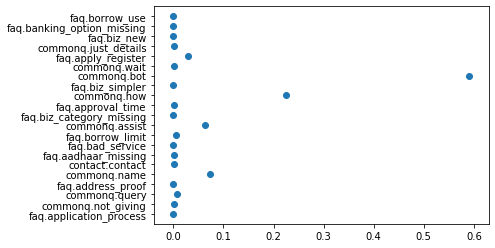

In [181]:
from matplotlib import pyplot as plt
import numpy as np
text = input()
pred = predictions(text)
res = get_final_output(pred, unique_intent)
plt.scatter(pred,Intents)
print(res[0])

In [183]:
Intents

['faq.application_process',
 'commonq.not_giving',
 'commonq.query',
 'faq.address_proof',
 'commonq.name',
 'contact.contact',
 'faq.aadhaar_missing',
 'faq.bad_service',
 'faq.borrow_limit',
 'commonq.assist',
 'faq.biz_category_missing',
 'faq.approval_time',
 'commonq.how',
 'faq.biz_simpler',
 'commonq.bot',
 'commonq.wait',
 'faq.apply_register',
 'commonq.just_details',
 'faq.biz_new',
 'faq.banking_option_missing',
 'faq.borrow_use']